## BIN 712 Final Project
#### Author: M. Nazif Tasbas
#### ID: 2593499
#### Date: 13.6.2023


In [1]:
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def scale_columns(df, cols):

    # Create a scaler object
    scaler = StandardScaler()

    # Scale the specified columns in the dataframe
    df_scaled = df.copy()
    df_scaled[cols] = scaler.fit_transform(df[cols])

    return df_scaled


def report_feature_importances(model, X_train):

    # Get the feature importances
    importances = model.feature_importances_

    # Create a dataframe of feature importances
    feature_importances = pd.DataFrame(
        {"feature": X_train.columns, "importance": importances})

    # Sort the dataframe by feature importance in descending order
    feature_importances = feature_importances.sort_values(
        "importance", ascending=False)

    # Add a new column for cumulative importance
    feature_importances["cumulative_importance"] = feature_importances["importance"].cumsum()

    return feature_importances


def calculate_elbow_point(model, X_train):
    """ identifies the elbow point for the model and returns the features with low importance"""

    # Report the feature importances for the  model
    feature_importances = report_feature_importances(model, X_train)

    # Sort the feature importances by importance in descending order
    feature_importances = feature_importances.sort_values(
        "importance", ascending=False)

    # Calculate the cumulative sum of feature importances
    feature_importances["cumulative_importance"] = feature_importances["importance"].cumsum()

    # Identify the elbow point
    elbow_point = feature_importances[feature_importances["cumulative_importance"]
                                      >= 0.9 * feature_importances["importance"].sum()].iloc[0]["feature"]

    return list(feature_importances[feature_importances["feature"] > elbow_point]["feature"])

In [3]:
# Read df
raw_df = pd.read_csv("final.csv")

# Drop irrelevant columns
cols_to_drop = ["mrna_start", "mrna_end", "mirna_start", "mirna_end",
                "mirna_dot_bracket_5to3", "mirna_sequence", "mirna_accession",
                "mre_region", "enst", "alignment_string"]
df = raw_df.drop(cols_to_drop, axis=1)

# Scaling columns
cols_to_scale = ["pred_energy", "ta_log10",
                 "ta_percentile_rank", "sps_mean", "sps_mean_percentile_rank"]
df = scale_columns(df, cols_to_scale)

# Train test split
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Init model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(score)

0.9829325058184639


# feature importances

In [4]:
report_df = report_feature_importances(model, X_train)
report_df

,feature,importance,cumulative_importance
0,pred_energy,0.646318,0.646318
10,mirna_conservation,0.143068,0.789386
6,ta_log10,0.056079,0.845465
8,sps_mean,0.047028,0.892493
4,seed_match,0.028118,0.920611
7,ta_percentile_rank,0.021544,0.942155
1,pred_num_basepairs,0.019932,0.962086
2,pred_seed_basepairs,0.017799,0.979886
3,anchor_a,0.013265,0.993151
5,seed_1_mismatch,0.006849,1.000000


# dropping features below elbow point

In [5]:
cols_below_elbow = calculate_elbow_point(model, X_train)
df = df.drop(cols_below_elbow, axis=1)

# refit


In [6]:
X = df.drop("label", axis=1)
y = df["label"]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Init model
model_after_elbow = xgb.XGBClassifier()
model_after_elbow.fit(X_train_new, y_train_new)
score = model_after_elbow.score(X_test_new, y_test_new)

print(score)

0.9579519006982157


In [10]:
df.head()

,pred_energy,label,pred_num_basepairs,pred_seed_basepairs,anchor_a,seed_match,seed_1_mismatch,mirna_conservation
0,-1.858451,1,20,6,0,1,0,2.0
1,-1.675276,1,17,6,0,1,0,2.0
2,-1.357772,1,19,6,0,0,1,2.0
3,-1.382196,1,19,6,0,0,1,2.0
4,-1.406619,1,18,6,0,1,0,2.0


In [9]:
df.columns


Index(['pred_energy', 'label', 'pred_num_basepairs', 'pred_seed_basepairs',
       'anchor_a', 'seed_match', 'seed_1_mismatch', 'mirna_conservation'],
      dtype='object')

# GridSearchCV


In [7]:
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

KeyboardInterrupt: 

In [ ]:
model_after_cv = xgb.XGBClassifier(**grid_search.best_params_)

model_after_cv.fit(X_train_new, y_train_new)
score_after_cv = model_after_cv.score(X_test_new, y_test_new)
print(f"accuracy after cv: {score_after_cv}")

accuracy after cv: 0.9590380139643134


# plot

score = model_after_elbow.score(X_test, y_test)


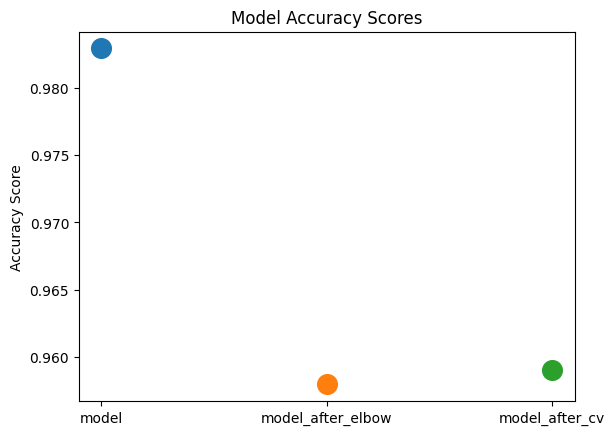

In [ ]:
scores = {
    "model": model.score(X_test, y_test),
    "model_after_elbow": model_after_elbow.score(X_test_new, y_test_new),
    "model_after_cv": model_after_cv.score(X_test_new, y_test_new)
}


for i, (ml_model, score) in enumerate(scores.items()):
    plt.scatter(i, score, s=200)

plt.xticks(range(len(scores)), list(scores.keys()))
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy Scores")

plt.show()